In [10]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
#
#   LEARN FCN00
#

from __future__ import print_function
import argparse
import os

import numpy as np
import pickle
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras.models import Model
from keras.layers import Input
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Concatenate
from keras.layers import merge
from keras.optimizers import Adam, SGD, RMSprop
from keras.preprocessing.image import list_pictures, array_to_img

from image_ext import list_pictures_in_multidir, load_imgs_asarray, img_dice_coeff
from create_fcn import create_fcn01, create_fcn02, create_fcn00

np.random.seed(2016)

In [11]:
def dice_coef(y_true, y_pred):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    intersection = K.sum(y_true * y_pred)
    return (2.*intersection + 1) / (K.sum(y_true) + K.sum(y_pred) + 1)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [12]:
def load_fnames(paths):
    f = open(paths)
    data1 = f.read()
    f.close()
    lines = data1.split('\n')
    #print(len(lines))
    # 最終行は空行なので消す
    del(lines[len(lines)-1])
    #print(len(lines))
    return lines

In [13]:
def make_fnames(fnames,fpath,fpath_mask,mask_ext):
    fnames_img = [];
    fnames_mask= [];
    
    for i in range(len(fnames)):
        fnames_img.append(fpath + '/' + fnames[i]);
        fnames_mask.append(fpath_mask + '/' + mask_ext + fnames[i]);
        
    return [fnames_img,fnames_mask]

In [14]:
#
#  MAIN STARTS FROM HERE
#
if __name__ == '__main__':
    
    target_size = (224, 224)
    dpath_this = './'
    dname_checkpoints = 'checkpoints_fcn00_LAB'
    dname_checkpoints_fcn01 = 'checkpoints_fcn01_LAB'
    dname_outputs = 'outputs'
    fname_architecture = 'architecture.json'
    fname_weights = "model_weights_{epoch:02d}.h5"
    fname_stats = 'stats01.npz'
    dim_ordering = 'channels_first'
    fname_history = "history.pkl"

    # definision of mode, LEARN or TEST or SHOW_HISTORY
    #mode = "LEARN"
    #mode = "SHOW_HISTORY"
    #mode = "TEST"

    # モデルを作成
    print('creating model fcn00 and fcn01...')
    #model_fcn02 = create_fcn02(target_size)
    model_fcn01 = create_fcn01(target_size)
    model_fcn00 = create_fcn00(target_size)
    
    if os.path.exists(dname_checkpoints) == 0:
        os.mkdir(dname_checkpoints)

creating model fcn00 and fcn01...


In [15]:
#
#   LEARNING MODE
#
mode = "LEARN"
if mode == "LEARN":
    # Read Learning Data
#    fnames = load_fnames('data/list_train_01.txt')
#    [fpaths_xs_train,fpaths_ys_train] = make_fnames(fnames,'data/img','data/mask','OperatorA_')
#    fnames = load_fnames('data.nnlab/list_train_01.txt')
    fnames = load_fnames('data/list_train_01.txt')
#    [fpaths_xs_train,fpaths_ys_train] = make_fnames(fnames,'data.nnlab/image','data.nnlab/gt','')
    [fpaths_xs_train,fpaths_ys_train] = make_fnames(fnames,'data.LAB/img','data.LAB/mask','OperatorA_')

    X_train = load_imgs_asarray(fpaths_xs_train, grayscale=False, target_size=target_size,
                                dim_ordering=dim_ordering)
    Y_train = load_imgs_asarray(fpaths_ys_train, grayscale=True, target_size=target_size,
                                dim_ordering=dim_ordering) 

    # Read Validation Data
#    fnames = load_fnames('data/list_valid_01.txt')
#    [fpaths_xs_valid,fpaths_ys_valid] = make_fnames(fnames,'data/img','data/mask','OperatorA_')
    fnames = load_fnames('data/list_valid_01.txt')
    [fpaths_xs_valid,fpaths_ys_valid] = make_fnames(fnames,'data.LAB/img','data.LAB/mask','OperatorA_')

    X_valid = load_imgs_asarray(fpaths_xs_valid, grayscale=False, target_size=target_size,
                                dim_ordering=dim_ordering)
    Y_valid = load_imgs_asarray(fpaths_ys_valid, grayscale=True, target_size=target_size,
                                dim_ordering=dim_ordering)     

    print('==> ' + str(len(X_train)) + ' training images loaded')
    print('==> ' + str(len(Y_train)) + ' training masks loaded')
    print('==> ' + str(len(X_valid)) + ' validation images loaded')
    print('==> ' + str(len(Y_valid)) + ' validation masks loaded')

    # 前処理
    print('computing mean and standard deviation...')
    mean = np.mean(X_train, axis=(0, 2, 3))
    std = np.std(X_train, axis=(0, 2, 3))
    print('==> mean: ' + str(mean))
    print('==> std : ' + str(std))

    print('saving mean and standard deviation to ' + fname_stats + '...')
    stats = {'mean': mean, 'std': std}
    np.savez(dname_checkpoints + '/' + fname_stats, **stats)
    print('==> done')

    print('globally normalizing data...')
    for i in range(3):
        X_train[:, i] = (X_train[:, i] - mean[i]) / std[i]
        X_valid[:, i] = (X_valid[:, i] - mean[i]) / std[i]
    Y_train /= 255
    Y_valid /= 255
    print('==> done')

==> 1452 training images loaded
==> 1452 training masks loaded
==> 527 validation images loaded
==> 527 validation masks loaded
computing mean and standard deviation...
==> mean: [143.01152 142.41399 107.15788]
==> std : [ 9.874445  8.032658 48.13504 ]
saving mean and standard deviation to stats01.npz...
==> done
globally normalizing data...
==> done


In [16]:
    init_from_fcn01 = 1
    
    if init_from_fcn01 == 1:
        # モデルに学習済のfcn01 Weightをロードする
        epoch = 100
        fname_weights = 'model_weights_%02d.h5'%(epoch)
        fpath_weights_fcn01 = os.path.join(dname_checkpoints_fcn01, fname_weights)
        model_fcn01.load_weights(fpath_weights_fcn01)
        #print('==> done')

        # load weights from Learned U-NET
        layer_names = ['conv1_1','conv1_2','conv2_1','conv2_2','conv3_1','conv3_2',
                       'conv4_1','conv4_2','conv5_1', 'conv5_2',
                    'up1_1', 'up1_2', 'up2_1', 'up2_2', 'up3_1', 'up3_2', 'up4_1', 
                       'up4_2', 'conv_fin']
        layer_names = ['conv1_1','conv1_2','conv2_1','conv2_2',
                    'up1_1', 'up1_2', 'up2_1', 'up2_2', 'conv_fin']

        print('copying layer weights')
        for name in layer_names:
            print(name)
            model_fcn00.get_layer(name).set_weights(model_fcn01.get_layer(name).get_weights())
            model_fcn00.get_layer(name).trainable = True

copying layer weights
conv1_1
conv1_2
conv2_1
conv2_2
up1_1
up1_2
up2_1
up2_2
conv_fin


In [17]:
    # 損失関数，最適化手法を定義
    adam = Adam(lr=1e-5)
    sgd = SGD(lr=1e-3, decay=1e-6, momentum=0.95, nesterov=True)
    #rmsprop = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
    model_fcn00.compile(optimizer=adam, loss=dice_coef_loss, metrics=[dice_coef])

    # 構造・重みを保存するディレクトリーの有無を確認
    dpath_checkpoints = os.path.join(dpath_this, dname_checkpoints)
    if not os.path.isdir(dpath_checkpoints):
        os.mkdir(dpath_checkpoints)

    # 重みを保存するためのオブジェクトを用意
    fname_weights = "model_weights_{epoch:02d}.h5"
    fpath_weights = os.path.join(dpath_checkpoints, fname_weights)
    checkpointer = ModelCheckpoint(filepath=fpath_weights, save_best_only=False)      

In [18]:
    # トレーニングを開始
    print('start training...')
    history = model_fcn00.fit(X_train[:,:,:,:], Y_train[:,:,:,:], batch_size=64, epochs=200, verbose=1,
                  shuffle=True, validation_data=(X_valid, Y_valid), callbacks=[checkpointer])

start training...
Train on 1452 samples, validate on 527 samples
Epoch 1/200
1452/1452 [==============================] - 70s 48ms/step - loss: -0.0342 - dice_coef: 0.0342 - val_loss: -0.0511 - val_dice_coef: 0.0511
Epoch 2/200
1452/1452 [==============================] - 68s 47ms/step - loss: -0.1025 - dice_coef: 0.1025 - val_loss: -0.2680 - val_dice_coef: 0.2680
Epoch 3/200
1452/1452 [==============================] - 68s 47ms/step - loss: -0.4275 - dice_coef: 0.4275 - val_loss: -0.5911 - val_dice_coef: 0.5911
Epoch 4/200
1452/1452 [==============================] - 68s 47ms/step - loss: -0.5899 - dice_coef: 0.5899 - val_loss: -0.6898 - val_dice_coef: 0.6898
Epoch 5/200
1452/1452 [==============================] - 68s 47ms/step - loss: -0.6835 - dice_coef: 0.6835 - val_loss: -0.7259 - val_dice_coef: 0.7259
Epoch 6/200
1452/1452 [==============================] - 68s 47ms/step - loss: -0.7195 - dice_coef: 0.7195 - val_loss: -0.7191 - val_dice_coef: 0.7191
Epoch 7/200
1452/1452 [======

1452/1452 [==============================] - 65s 45ms/step - loss: -0.8655 - dice_coef: 0.8655 - val_loss: -0.8495 - val_dice_coef: 0.8495
Epoch 55/200
1452/1452 [==============================] - 65s 45ms/step - loss: -0.8743 - dice_coef: 0.8743 - val_loss: -0.8513 - val_dice_coef: 0.8513
Epoch 56/200
1452/1452 [==============================] - 66s 45ms/step - loss: -0.8699 - dice_coef: 0.8699 - val_loss: -0.8435 - val_dice_coef: 0.8435
Epoch 57/200
1452/1452 [==============================] - 66s 45ms/step - loss: -0.8759 - dice_coef: 0.8759 - val_loss: -0.8491 - val_dice_coef: 0.8491
Epoch 58/200
1452/1452 [==============================] - 66s 45ms/step - loss: -0.8736 - dice_coef: 0.8736 - val_loss: -0.8551 - val_dice_coef: 0.8551
Epoch 59/200
1452/1452 [==============================] - 66s 45ms/step - loss: -0.8766 - dice_coef: 0.8766 - val_loss: -0.8452 - val_dice_coef: 0.8452
Epoch 60/200
1452/1452 [==============================] - 66s 45ms/step - loss: -0.8752 - dice_coef: 

Epoch 108/200
1452/1452 [==============================] - 65s 45ms/step - loss: -0.9126 - dice_coef: 0.9126 - val_loss: -0.8227 - val_dice_coef: 0.8227
Epoch 109/200
1452/1452 [==============================] - 65s 45ms/step - loss: -0.8961 - dice_coef: 0.8961 - val_loss: -0.8441 - val_dice_coef: 0.8441
Epoch 110/200
1452/1452 [==============================] - 65s 45ms/step - loss: -0.9150 - dice_coef: 0.9150 - val_loss: -0.8564 - val_dice_coef: 0.8564
Epoch 111/200
1452/1452 [==============================] - 65s 45ms/step - loss: -0.9207 - dice_coef: 0.9207 - val_loss: -0.8486 - val_dice_coef: 0.8486
Epoch 112/200
1452/1452 [==============================] - 65s 45ms/step - loss: -0.9198 - dice_coef: 0.9198 - val_loss: -0.8476 - val_dice_coef: 0.8476
Epoch 113/200
1452/1452 [==============================] - 65s 45ms/step - loss: -0.9210 - dice_coef: 0.9210 - val_loss: -0.8585 - val_dice_coef: 0.8585
Epoch 114/200
1452/1452 [==============================] - 65s 45ms/step - loss: -

1452/1452 [==============================] - 65s 45ms/step - loss: -0.9486 - dice_coef: 0.9486 - val_loss: -0.8369 - val_dice_coef: 0.8369
Epoch 162/200
1452/1452 [==============================] - 65s 45ms/step - loss: -0.9452 - dice_coef: 0.9452 - val_loss: -0.8524 - val_dice_coef: 0.8524
Epoch 163/200
1452/1452 [==============================] - 65s 45ms/step - loss: -0.9422 - dice_coef: 0.9422 - val_loss: -0.8554 - val_dice_coef: 0.8554
Epoch 164/200
1452/1452 [==============================] - 65s 45ms/step - loss: -0.9434 - dice_coef: 0.9434 - val_loss: -0.8385 - val_dice_coef: 0.8385
Epoch 165/200
1452/1452 [==============================] - 65s 45ms/step - loss: -0.9425 - dice_coef: 0.9425 - val_loss: -0.8471 - val_dice_coef: 0.8471
Epoch 166/200
1452/1452 [==============================] - 65s 45ms/step - loss: -0.9491 - dice_coef: 0.9491 - val_loss: -0.8521 - val_dice_coef: 0.8521
Epoch 167/200
1452/1452 [==============================] - 65s 45ms/step - loss: -0.9455 - dice_

KeyboardInterrupt: 

In [11]:
    # Save History
    f = open(dname_checkpoints + '/' + fname_history,'wb')
    pickle.dump(history.history,f)
    f.close

<function BufferedWriter.close>

In [27]:
#
#  TEST MODE
#
mode = 'TEST'
if mode == "TEST":
    # Prediction (test) mode
    
    # Read Test Data
    #fnames = load_fnames('data/list_test_01.txt')
    fnames = load_fnames('data.nnlab/list_test_01.txt')

    #[fpaths_xs_test,fpaths_ys_test] = make_fnames(fnames,'data.LAB/img','data.LAB/mask','OperatorA_')
    [fpaths_xs_test,fpaths_ys_test] = make_fnames(fnames,'data.nnlab.LAB/img','data.nnlab.LAB/gt','')

    X_test = load_imgs_asarray(fpaths_xs_test, grayscale=False, target_size=target_size,
                                dim_ordering=dim_ordering)
    Y_test = load_imgs_asarray(fpaths_ys_test, grayscale=True, target_size=target_size,
                                dim_ordering=dim_ordering)

    # トレーニング時に計算した平均・標準偏差をロード    
    print('loading mean and standard deviation from ' + fname_stats + '...')
    stats = np.load(dname_checkpoints + '/' + fname_stats)
    mean = stats['mean']
    std = stats['std']
    print('==> mean: ' + str(mean))
    print('==> std : ' + str(std))

    for i in range(3):
        X_test[:, i] = (X_test[:, i] - mean[i]) / std[i]
    print('==> done')

loading mean and standard deviation from stats01.npz...
==> mean: [143.01152 142.41399 107.15788]
==> std : [ 9.874445  8.032658 48.13504 ]
==> done


==> done
saving outputs as images...
==> done
0: Dice eval : 0.000000


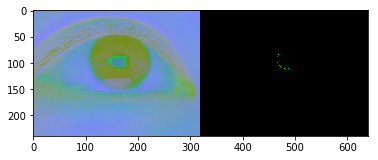

1: Dice eval : 0.000000


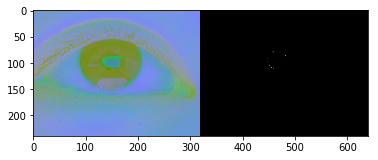

2: Dice eval : 0.000000


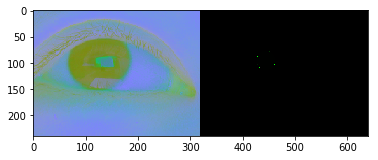

3: Dice eval : 0.000000


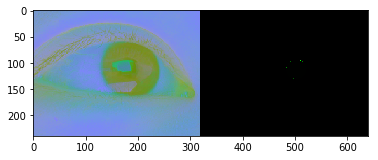

4: Dice eval : 0.000000


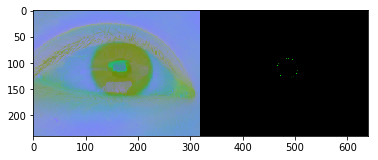

5: Dice eval : 0.000000


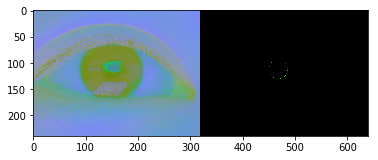

6: Dice eval : 0.000000


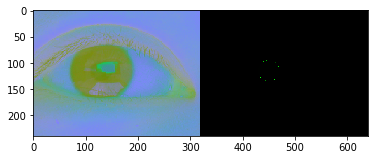

7: Dice eval : 0.000000


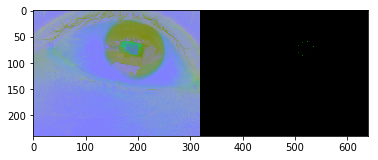

8: Dice eval : 0.000000


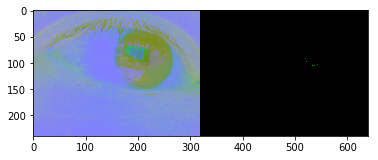

9: Dice eval : 0.000000


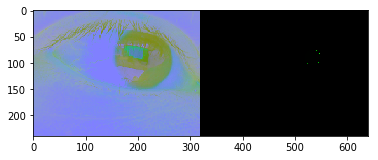

10: Dice eval : 0.000000


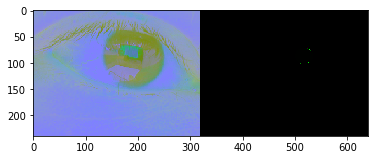

11: Dice eval : 0.000000


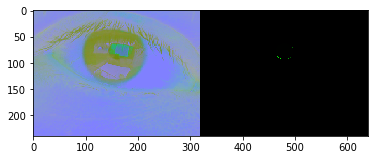

12: Dice eval : 0.000000


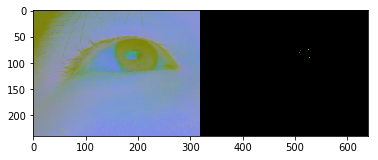

13: Dice eval : 0.000000


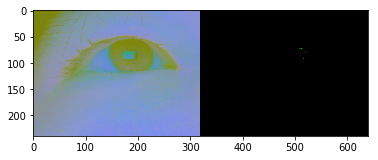

14: Dice eval : 0.000000


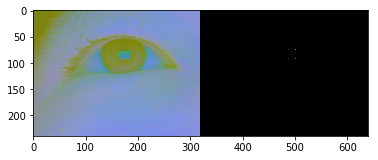

15: Dice eval : 0.000000


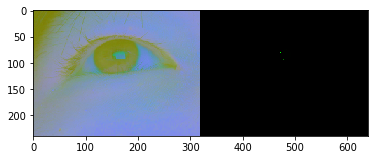

16: Dice eval : 0.000000


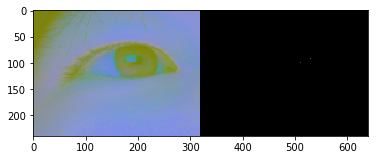

17: Dice eval : 0.000000


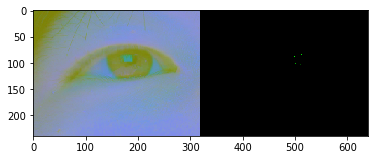

18: Dice eval : 0.000000


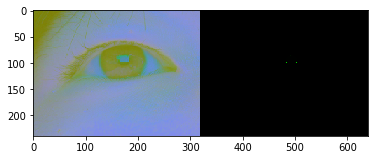

19: Dice eval : 0.000000


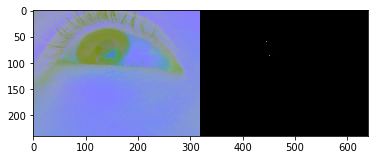

20: Dice eval : 0.000000


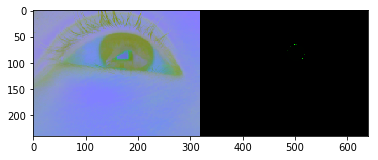

21: Dice eval : 0.000000


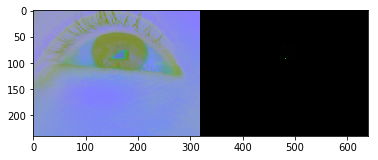

22: Dice eval : 0.000000


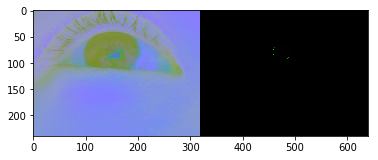

23: Dice eval : 0.000000


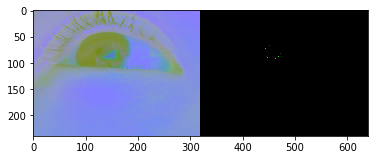

24: Dice eval : 0.000000


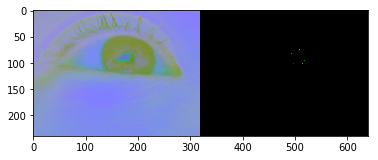

25: Dice eval : 0.000000


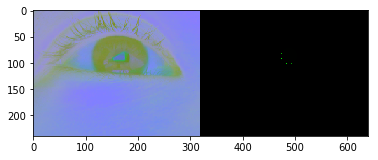

26: Dice eval : 0.000000


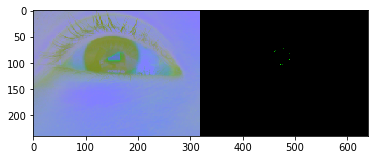

27: Dice eval : 0.000000


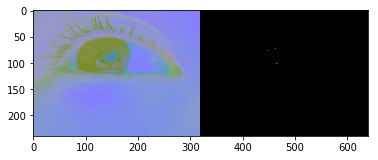

28: Dice eval : 0.000000


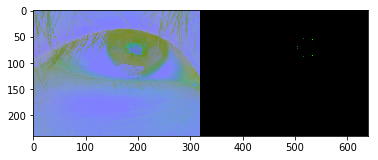

29: Dice eval : 0.000000


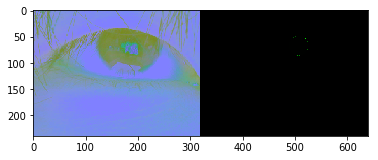

30: Dice eval : 0.000000


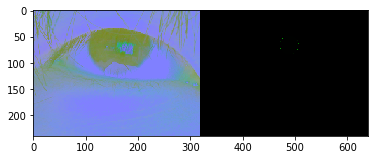

31: Dice eval : 0.000000


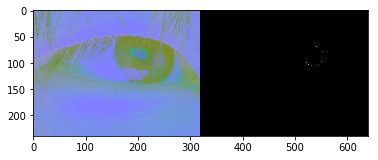

32: Dice eval : 0.000000


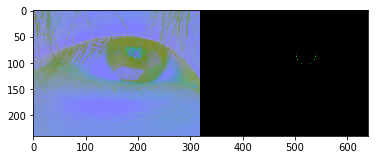

33: Dice eval : 0.000000


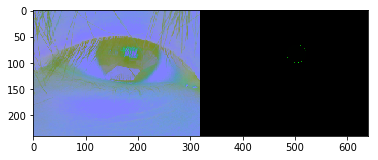

34: Dice eval : 0.000000


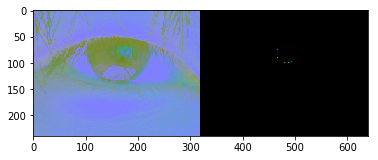

35: Dice eval : 0.000000


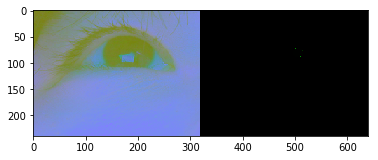

36: Dice eval : 0.000000


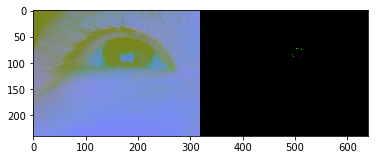

37: Dice eval : 0.000000


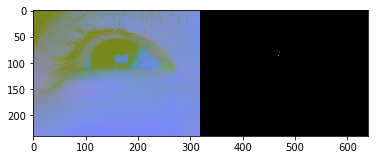

38: Dice eval : 0.000000


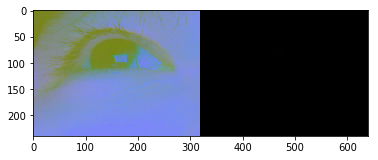

39: Dice eval : 0.000000


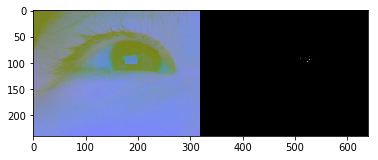

40: Dice eval : 0.000000


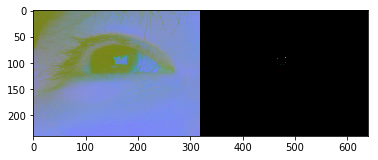

41: Dice eval : 0.000000


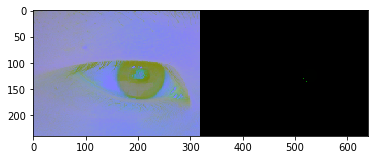

42: Dice eval : 0.000000


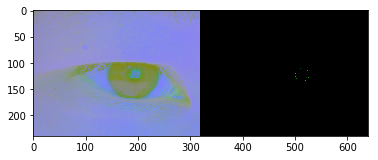

43: Dice eval : 0.000000


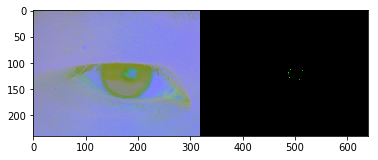

44: Dice eval : 0.000000


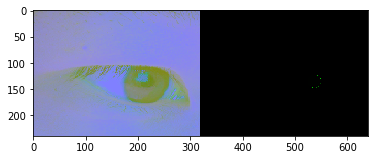

45: Dice eval : 0.000000


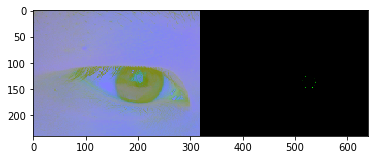

46: Dice eval : 0.000000


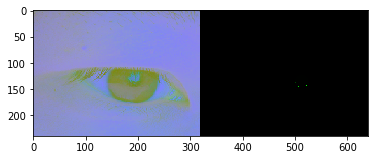

47: Dice eval : 0.000000


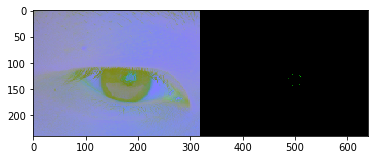

179: Dice eval av. : 0.000000


In [28]:
    from PIL import Image
    import matplotlib.pyplot as plt

    # 学習済みの重みをロード
    epoch = 179
    fname_weights = 'model_weights_%02d.h5'%(epoch)
    fpath_weights = os.path.join(dname_checkpoints, fname_weights)
    model_fcn00.load_weights(fpath_weights)
    print('==> done')

    # テストを開始
    outputs = model_fcn00.predict(X_test)
    #    outputs = model_fcn02.predict(X_test)

    # 出力を画像として保存
    dname_outputs = './outputs/'
    if not os.path.isdir(dname_outputs):
        print('create directory: %s'%(dname_outputs))
        os.mkdir(dname_outputs)

    print('saving outputs as images...')
    n = 0
    for i, array in enumerate(outputs):
        array = np.where(array > 0.5, 1, 0) # 二値に変換
        array = array.astype(np.float32)
        img_out = array_to_img(array, dim_ordering)
        # fpath_out = os.path.join(dname_outputs, fnames[i])
        fpath_out = os.path.join(dname_outputs, "%05d.png"%(n))
        img_out.save(fpath_out)
        n = n + 1

    print('==> done')

    n = 0
    dice_eval = []

    for i in range(len(fpaths_xs_test)):
        # テスト画像
        im1 = Image.open(fpaths_xs_test[i])
        im1 = im1.resize((320,240)) 
        # 出力結果
        im2 = Image.open(os.path.join(dname_outputs, "%05d.png"%(n)))
        im2 = im2.resize((320,240))
        # Grond Truth
        im3 = Image.open(fpaths_ys_test[i])
        im3 = im3.resize((320,240))
        im3 = im3.convert('L')
        
        im2_d = np.zeros((240,320,3), 'uint8')
        im2_d[:,:,0] = np.array(im2)
        im2_d[:,:,1] = np.array(im3)*255
        im2_d[:,:,2] = 0

        # Compute dice coeff
        im2a = np.array(im2)
        im2a[im2a > 0] = 1
        im3a = np.array(im3)
        im3a[im3a > 0] = 1

        overlap_a = np.array(im2a) * np.array(im3a)
        overlap_b = np.array(im2a) + np.array(im3a)
        #print('%03d: Dice Coeff = %f'%(i, 2*sum(sum(overlap_a))/sum(sum(overlap_b))))
        #print('%f'%img_dice_coeff(im2,im3))
        dice_eval.append(2*sum(sum(overlap_a))/sum(sum(overlap_b)))

        print('%d: Dice eval : %f'%(n,2*sum(sum(overlap_a))/sum(sum(overlap_b))))  
        
        plt.imshow(np.hstack((np.array(im1),np.array(im2_d))))
        plt.show()

        n = n + 1
    
    print('%d: Dice eval av. : %f'%(epoch,np.mean(np.array(dice_eval))))

checkpoints_fcn00/history.pkl


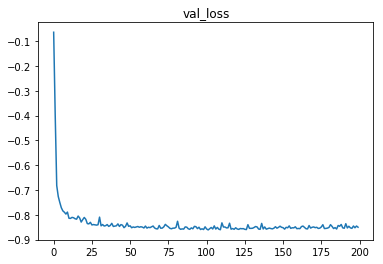

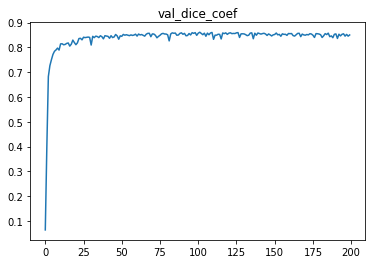

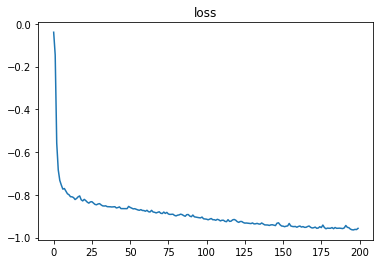

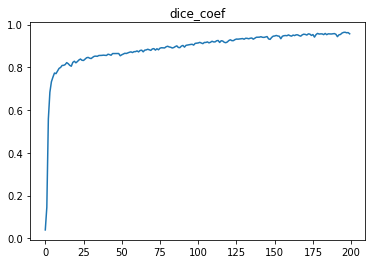

In [19]:
#
#   Show History
#
mode = "SHOW_HISTORY"
if mode == "SHOW_HISTORY":
    # load pickle
    print(dname_checkpoints + '/' + fname_history)
    history = pickle.load(open(dname_checkpoints + '/' + fname_history, 'rb'))
    
    for k in history.keys():
        plt.plot(history[k])
        plt.title(k)
        plt.show()
